## Load the Data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import folium
import math
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
housing_price = pd.read_csv('.\Housing Price Dubai UAE.csv')
housing_price.head()

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\aalma\AppData\Local\Temp\ipykernel_14104\3501704961.py:1: SyntaxWarning: invalid escape sequence '\H'
  housing_price = pd.read_csv('.\Housing Price Dubai UAE.csv')


,id,neighborhood,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,...,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet
0,5528049,Palm Jumeirah,25.113208,55.138932,2700000,1079,2502.32,1,2,Medium,...,False,False,True,False,False,False,False,False,True,False
1,6008529,Palm Jumeirah,25.106809,55.151201,2850000,1582,1801.52,2,2,Medium,...,False,False,True,True,False,False,False,False,True,False
2,6034542,Jumeirah Lake Towers,25.063302,55.137728,1150000,1951,589.44,3,5,Medium,...,False,True,True,True,False,False,False,True,True,True
3,6326063,Culture Village,25.227295,55.341761,2850000,2020,1410.89,2,3,Low,...,False,False,False,False,False,False,False,False,False,False
4,6356778,Palm Jumeirah,25.114275,55.139764,1729200,507,3410.65,0,1,Medium,...,False,True,True,True,True,False,False,True,True,False


In [3]:
housing_price.describe()

,id,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms
count,1.905000e+03,1905.000000,1905.000000,1.905000e+03,1905.000000,1905.000000,1905.000000,1905.000000
mean,7.573308e+06,25.116538,55.212338,2.085830e+06,1417.050394,1327.243785,1.793176,2.512861
std,1.925252e+05,0.062647,0.068794,2.913200e+06,891.487639,668.473559,0.949489,1.063117
min,5.528049e+06,24.865992,55.069311,2.200000e+05,294.000000,361.870000,0.000000,1.000000
25%,7.560167e+06,25.072791,55.145389,8.900000e+05,840.000000,870.920000,1.000000,2.000000
50%,7.631829e+06,25.096700,55.207506,1.400000e+06,1271.000000,1169.590000,2.000000,2.000000
75%,7.670328e+06,25.188130,55.271797,2.200000e+06,1703.000000,1622.500000,2.000000,3.000000
max,7.706643e+06,25.273623,55.441623,3.500000e+07,9576.000000,4805.870000,5.000000,6.000000


In [4]:
housing_price.shape

(1905, 38)

In [5]:
housing_price.isna().sum()

id                     0
neighborhood           0
latitude               0
longitude              0
price                  0
size_in_sqft           0
price_per_sqft         0
no_of_bedrooms         0
no_of_bathrooms        0
quality                0
maid_room              0
unfurnished            0
balcony                0
barbecue_area          0
built_in_wardrobes     0
central_ac             0
childrens_play_area    0
childrens_pool         0
concierge              0
covered_parking        0
kitchen_appliances     0
lobby_in_building      0
maid_service           0
networked              0
pets_allowed           0
private_garden         0
private_gym            0
private_jacuzzi        0
private_pool           0
security               0
shared_gym             0
shared_pool            0
shared_spa             0
study                  0
vastu_compliant        0
view_of_landmark       0
view_of_water          0
walk_in_closet         0
dtype: int64

## EDA

In [6]:
# Create a map
m_1 = folium.Map(location=[25.2048,55.2708], tiles='openstreetmap', zoom_start=10)

# Add points to the map
mc = MarkerCluster()
for idx, row in housing_price.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        mc.add_child(Marker([row['latitude'], row['longitude']]))
m_1.add_child(mc)

m_1

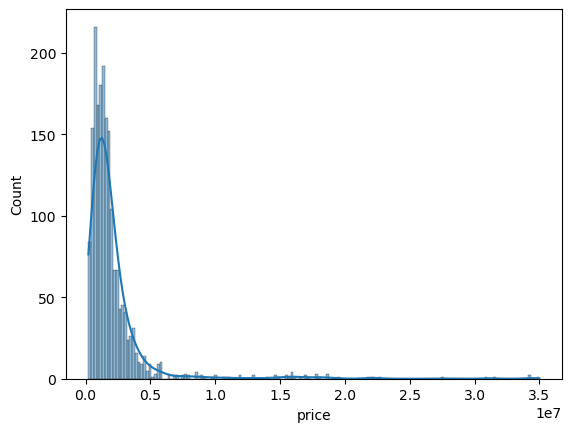

In [7]:
# distribution of the target variable- price
sns.histplot(housing_price['price'], kde=True)
plt.show()


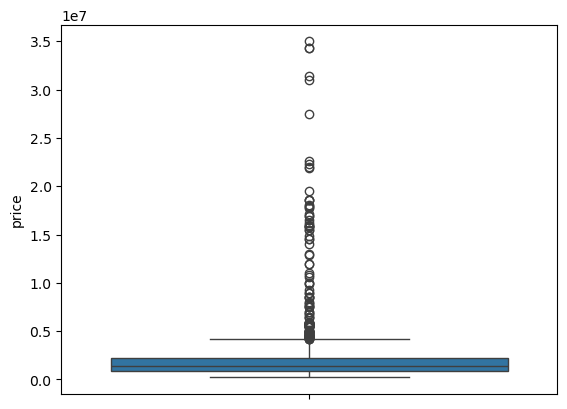

In [8]:
# see the outliers in the price
sns.boxplot(housing_price['price'])
plt.show()


In [9]:
# remove the outliers
Q1 = housing_price['price'].quantile(0.25) # 1st quartile
Q3 = housing_price['price'].quantile(0.75) # 3rd quartile
IQR = Q3 - Q1 # Interquartile range
# remove the outliers
housing_price_cleaned = housing_price[(housing_price['price'] >= (Q1 - 1.5 * IQR)) & (housing_price['price'] <= (Q3 + 1.5 * IQR))] 

# print the shape of the original and cleaned data
housing_price.shape, housing_price_cleaned.shape

# print the number of outliers in the price
print(f"No. of outliers in price: {housing_price.shape[0] - housing_price_cleaned.shape[0]}")

No. of outliers in price: 128


In [10]:
housing_price_cleaned.head()

,id,neighborhood,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,...,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet
0,5528049,Palm Jumeirah,25.113208,55.138932,2700000,1079,2502.32,1,2,Medium,...,False,False,True,False,False,False,False,False,True,False
1,6008529,Palm Jumeirah,25.106809,55.151201,2850000,1582,1801.52,2,2,Medium,...,False,False,True,True,False,False,False,False,True,False
2,6034542,Jumeirah Lake Towers,25.063302,55.137728,1150000,1951,589.44,3,5,Medium,...,False,True,True,True,False,False,False,True,True,True
3,6326063,Culture Village,25.227295,55.341761,2850000,2020,1410.89,2,3,Low,...,False,False,False,False,False,False,False,False,False,False
4,6356778,Palm Jumeirah,25.114275,55.139764,1729200,507,3410.65,0,1,Medium,...,False,True,True,True,True,False,False,True,True,False


In [11]:
# remove the tab character from column names
housing_price_cleaned.columns = housing_price_cleaned.columns.str.replace('\t', '')

# remove the unnecessary columns
housing_price = housing_price_cleaned.drop(columns=['id', 'latitude', 'longitude', 'private_pool', 'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study', 'vastu_compliant', 'view_of_landmark', 'view_of_water', 'walk_in_closet'])
housing_price = housing_price.drop(columns=['balcony', 'concierge', 'covered_parking', 'kitchen_appliances', 'lobby_in_building', 'maid_service', 'networked', 'pets_allowed', 'private_garden', 'private_gym', 'private_jacuzzi','maid_room', 'unfurnished', 'barbecue_area', 'built_in_wardrobes', 'central_ac','childrens_play_area', 'childrens_pool'])
housing_price.head()

,neighborhood,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality
0,Palm Jumeirah,2700000,1079,2502.32,1,2,Medium
1,Palm Jumeirah,2850000,1582,1801.52,2,2,Medium
2,Jumeirah Lake Towers,1150000,1951,589.44,3,5,Medium
3,Culture Village,2850000,2020,1410.89,2,3,Low
4,Palm Jumeirah,1729200,507,3410.65,0,1,Medium


In [12]:
housing_price.shape

(1777, 7)

In [13]:
housing_price.quality.unique()

array(['Medium', 'Low', 'High', 'Ultra'], dtype=object)

In [14]:
housing_price.neighborhood.value_counts()

neighborhood
Dubai Marina                         283
Downtown Dubai                       261
Jumeirah Village Circle              200
Palm Jumeirah                        146
Jumeirah Beach Residence             103
Business Bay                          91
Jumeirah Lake Towers                  70
Dubai Hills Estate                    53
The Views                             47
Dubai Creek Harbour (The Lagoons)     38
Mohammed Bin Rashid City              31
Greens                                30
DIFC                                  29
Motor City                            27
Town Square                           27
Dubai Harbour                         27
Jumeirah                              27
Dubai Sports City                     25
Al Furjan                             23
DAMAC Hills                           21
Meydan                                17
Old Town                              16
Umm Suqeim                            13
City Walk                             12
Dub

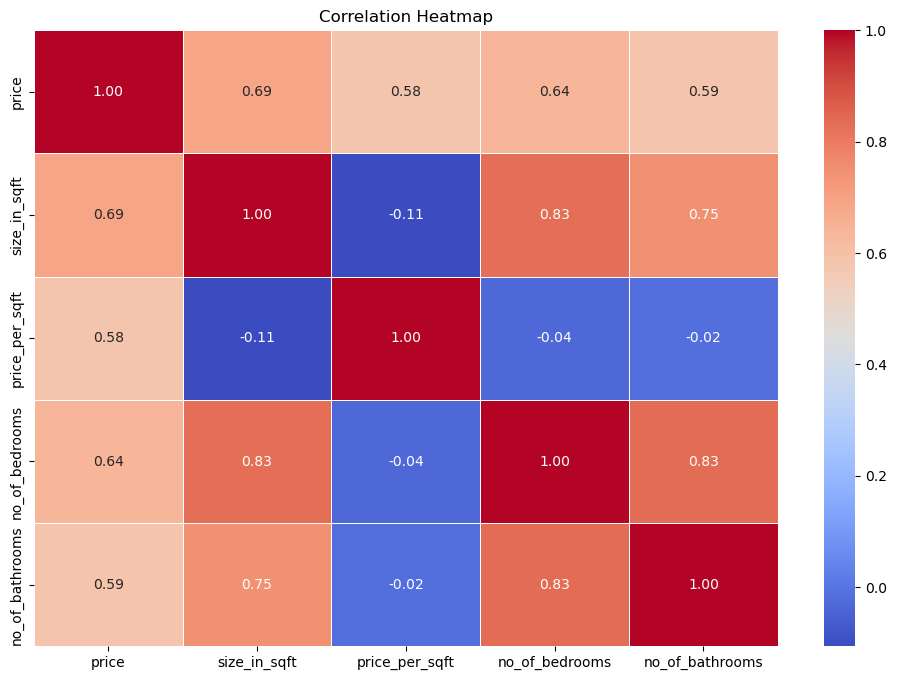

In [15]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
numerical_cols = housing_price.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(housing_price[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

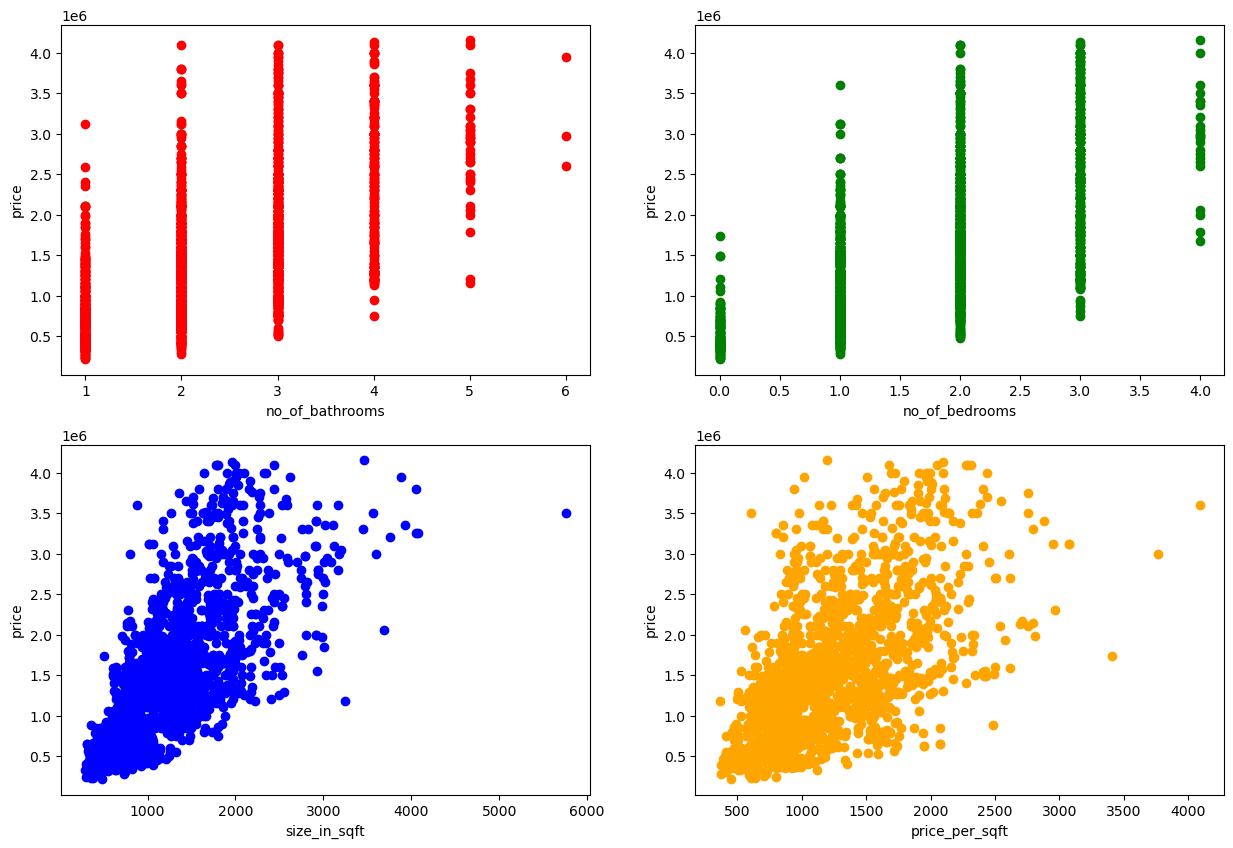

In [16]:
# scatter plot of price vs. features
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(housing_price['no_of_bathrooms'], housing_price['price'], color='red')
plt.xlabel('no_of_bathrooms')
plt.ylabel('price')
plt.subplot(2, 2, 2)
plt.scatter(housing_price['no_of_bedrooms'], housing_price['price'], color='green')
plt.xlabel('no_of_bedrooms')
plt.ylabel('price')
plt.subplot(2, 2, 3)
plt.scatter(housing_price['size_in_sqft'], housing_price['price'], color='blue')
plt.xlabel('size_in_sqft')
plt.ylabel('price')
plt.subplot(2, 2, 4)
plt.scatter(housing_price['price_per_sqft'], housing_price['price'], color='orange')
plt.xlabel('price_per_sqft')
plt.ylabel('price')
plt.show()


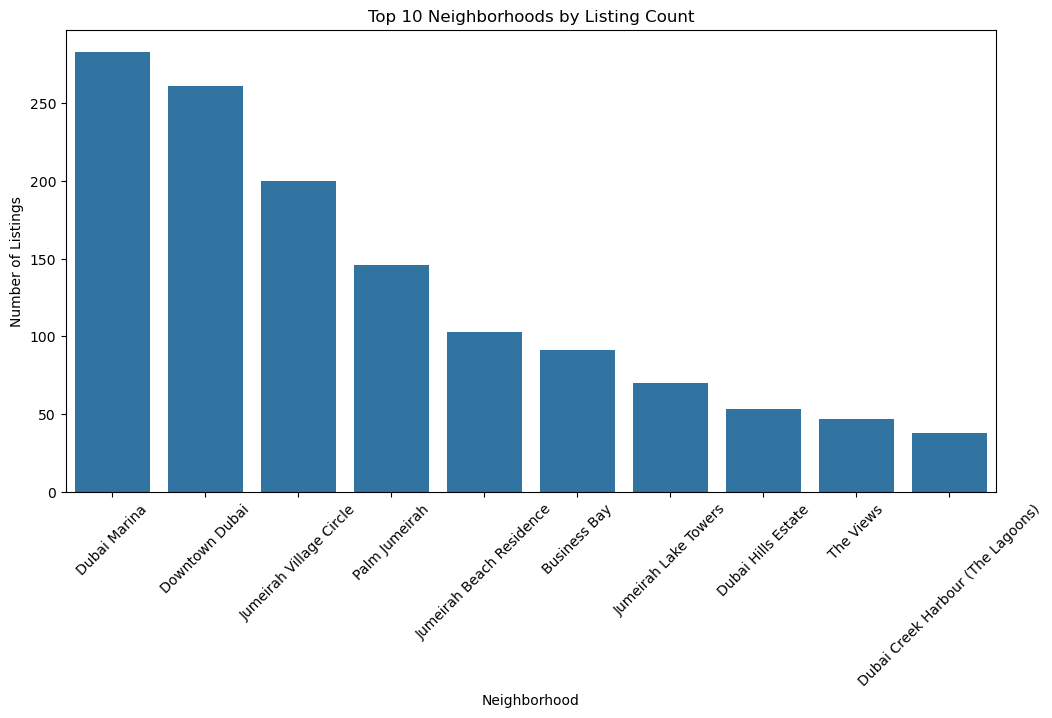

In [17]:
# Count plot for categorical data (neighborhood)
plt.figure(figsize=(12, 6))
top_neighborhoods = housing_price["neighborhood"].value_counts().nlargest(10)  # Top 10 neighborhoods
sns.barplot(x=top_neighborhoods.index, y=top_neighborhoods.values)
plt.xticks(rotation=45)
plt.title("Top 10 Neighborhoods by Listing Count")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Listings")
plt.show()

In [18]:
# one-hot encode the neighborhood column
housing_price = housing_price.drop(columns=['quality'])
housing_price.head()

,neighborhood,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms
0,Palm Jumeirah,2700000,1079,2502.32,1,2
1,Palm Jumeirah,2850000,1582,1801.52,2,2
2,Jumeirah Lake Towers,1150000,1951,589.44,3,5
3,Culture Village,2850000,2020,1410.89,2,3
4,Palm Jumeirah,1729200,507,3410.65,0,1


In [19]:
# Encode categorical variables
housing_price["neighborhood"] = LabelEncoder().fit_transform(housing_price["neighborhood"])


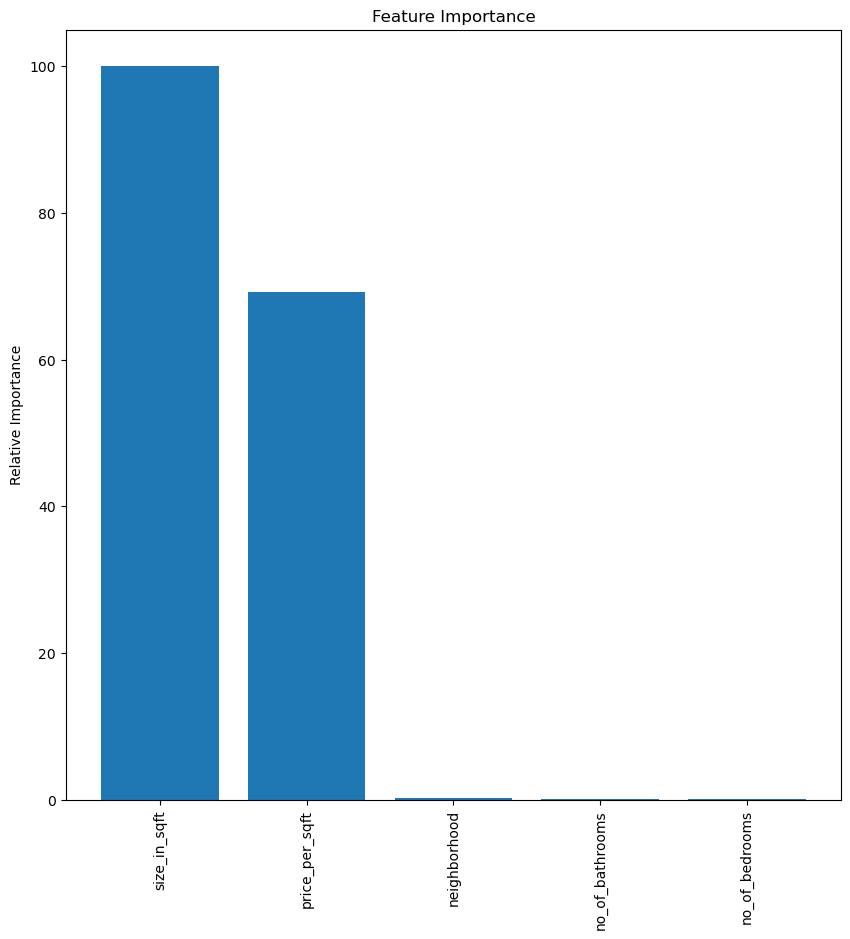

In [20]:
# See the feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor
X = housing_price.drop(columns=['price'])
y = housing_price['price']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# get the feature importance
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# sort the feature importance in descending order
sorted_idx = np.argsort(feature_importance)[::-1]
pos = np.arange(sorted_idx.shape[0])
plt.figure(figsize=(10, 10))
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, X.columns[sorted_idx], rotation=90)
plt.ylabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

## Train the XGboost

In [21]:
# Train the XGBoost model
X = housing_price.drop(columns=['price'])
y = housing_price['price']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Show model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the model performance
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")

MAE: 36427.348
RMSE: 5790897664.000
R2 Score: 0.992
